<a href="https://colab.research.google.com/github/mjgpinheiro/Physics_models/blob/main/Vlasov_1D1V_TensorNetworks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Bibliotecas carregadas com sucesso!
Resolução: 1024 × 1024 = 1,048,576 pontos
dx = 0.0123, dv = 0.0117
Condição inicial criada.
Densidade integrada inicial: 1.000000
Conversão para QTT concluída em 1.10 s
Ranks TT máximos iniciais: 1
Número de parâmetros: 2 (vs 1,048,576 pontos originais)
Compressão: 0.0002% do tamanho original
t =   0.0 | Rank máx =   1 | Energia total = 1.250199
t =   2.0 | Rank máx =  80 | Energia total = 1.266633
t =   4.0 | Rank máx =  80 | Energia total = 1.285832
t =   6.0 | Rank máx =  80 | Energia total = 1.283138
t =   8.0 | Rank máx =  80 | Energia total = 1.269967
t =  10.0 | Rank máx =  80 | Energia total = 1.270329
t =  12.0 | Rank máx =  80 | Energia total = 1.286921
t =  14.0 | Rank máx =  80 | Energia total = 1.282793
t =  16.0 | Rank máx =  80 | Energia total = 1.258728
t =  18.0 | Rank máx =  80 | Energia total = 1.249793
t =  20.0 | Rank máx =  80 | Energia total = 1.271544
t =  22.0 | Rank máx =  80 | Energia total = 1.294331
t =  24.0 | Rank máx =

/tmp/ipython-input-4244267861.py:136: UserWarning: Log scale: values of z <= 0 have been masked
  plt.contourf(x, v, f_final.T, levels=100, cmap='viridis', norm=LogNorm(1e-6, f_final.max()))


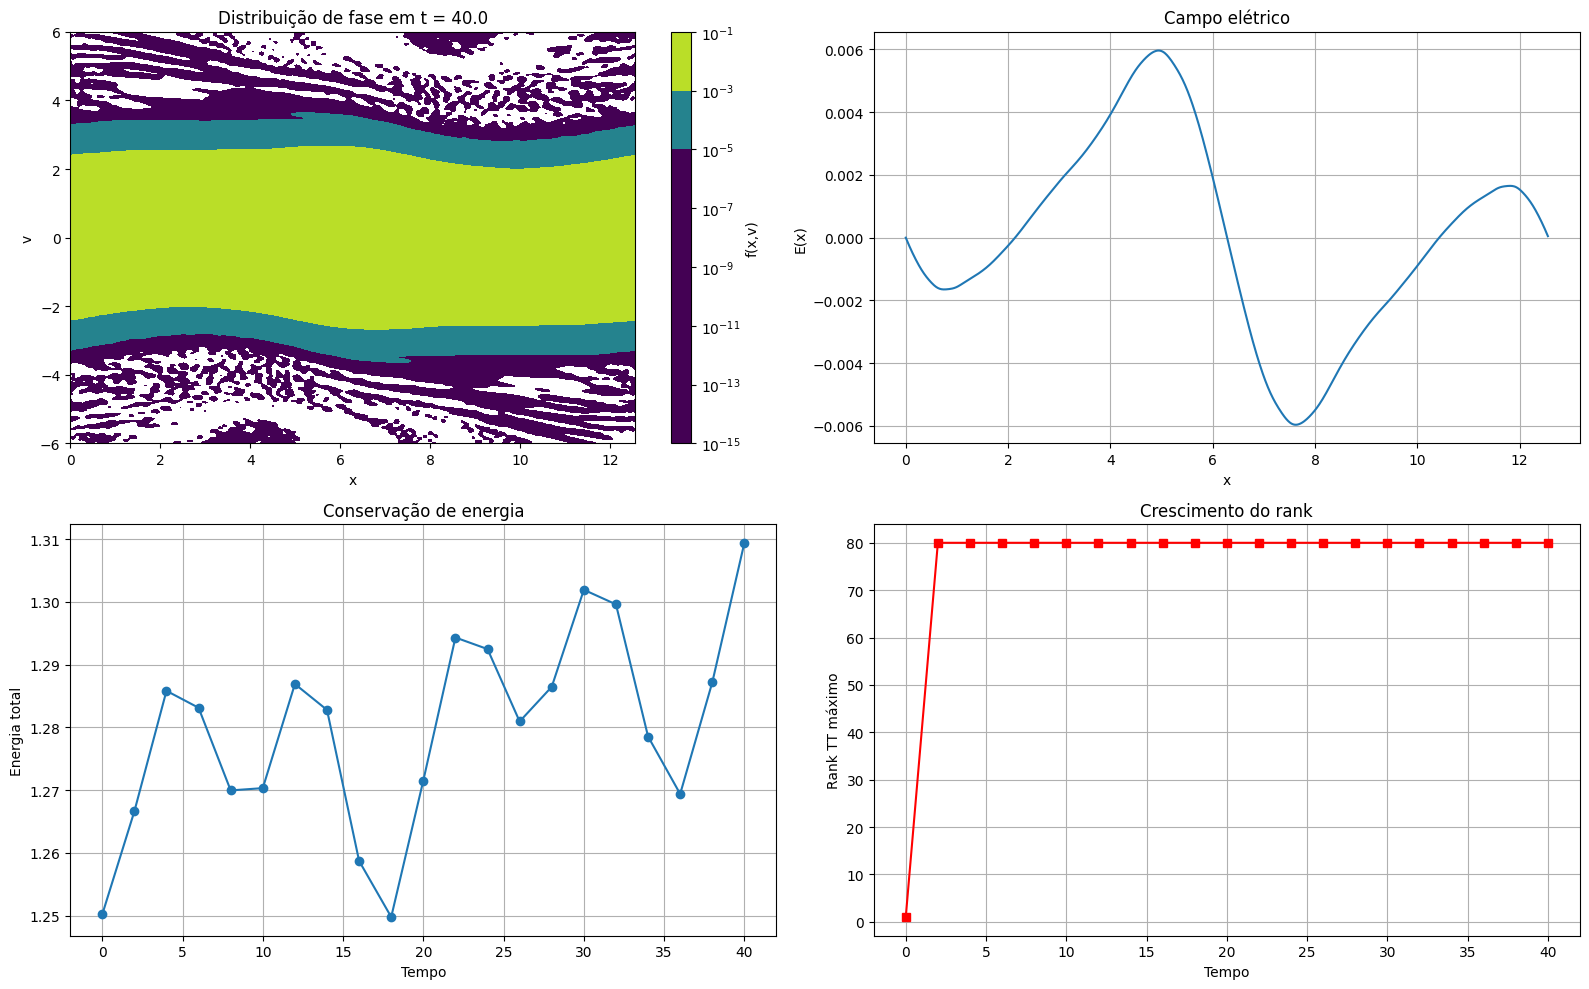

In [7]:
# Instalação (só necessário no Google Colab ou ambiente novo)
!pip install tntorch --quiet

# Importações
import numpy as np
import tntorch as tn
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import time

print("Bibliotecas carregadas com sucesso!")

# Parâmetros do problema
Lx = 4 * np.pi                  # Domínio espacial
vmax = 6.0                      # Velocidade máxima (|v| ≤ vmax)
Nx = 2**10                      # Pontos em x (potência de 2 → QTT automático)
Nv = 2**10                      # Pontos em v
dx = Lx / Nx
dv = 2 * vmax / Nv

x = np.linspace(0, Lx, Nx, endpoint=False)
v = np.linspace(-vmax, vmax, Nv)

print(f"Resolução: {Nx} × {Nv} = {Nx*Nv:,} pontos")
print(f"dx = {dx:.4f}, dv = {dv:.4f}")

# Condição inicial – Instabilidade two-stream
epsilon = 0.05
k = 2 * np.pi / Lx

f0 = (1 + epsilon * np.cos(k * x[:, np.newaxis])) * (
    0.5 * np.exp(-(v[np.newaxis, :] - 1.0)**2 / 0.5) +
    0.5 * np.exp(-(v[np.newaxis, :] + 1.0)**2 / 0.5)
) / np.sqrt(2 * np.pi * 0.5)

# Normalização para densidade ≈ 1
f0 /= np.sum(f0) * dx * dv

print("Condição inicial criada.")
print(f"Densidade integrada inicial: {np.sum(f0)*dx*dv:.6f}")

# Conversão para Tensor Train / QTT (automático!)
start = time.time()
f_tn = tn.Tensor(f0)                     # QTT automático porque Nx=Nv=2**10
f_tn.round_tt(eps=1e-8, rmax=64)         # Compressão inicial (parâmetro correto: rmax)

print(f"Conversão para QTT concluída em {time.time()-start:.2f} s")
print(f"Ranks TT máximos iniciais: {max(f_tn.ranks_tt)}")
print(f"Número de parâmetros: {f_tn.dim():,} (vs {Nx*Nv:,} pontos originais)")
print(f"Compressão: {f_tn.dim() / (Nx*Nv) * 100:.4f}% do tamanho original")

# Função de Poisson 1D (periódico)
def solve_poisson(rho):
    rho_hat = np.fft.fft(rho - 1.0)
    kx = np.fft.fftfreq(Nx, d=dx) * 2 * np.pi
    kx[0] = 1e-12  # Evita divisão por zero
    E_hat = -1j * rho_hat / kx
    return np.real(np.fft.ifft(E_hat))

# Passo temporal com Strang splitting (simplificado)
def time_step(f_tn, E_current, dt):
    f_full = f_tn.numpy().reshape(Nx, Nv)

    # 1. Meio passo em v
    shift_v = -E_current * (dt / 2) / dv
    f_half_v = np.zeros_like(f_full)
    for i in range(Nx):
        f_half_v[i] = np.interp(v - shift_v[i], v, f_full[i],
                                left=f_full[i,0], right=f_full[i,-1])

    # 2. Passo completo em x (shift inteiro simples)
    f_adv_x = np.zeros_like(f_half_v)
    for j in range(Nv):
        shift_cells = v[j] * dt / dx
        int_shift = int(np.round(shift_cells))
        f_adv_x[:, j] = np.roll(f_half_v[:, j], -int_shift)

    # Atualizar campo elétrico
    rho = np.sum(f_adv_x, axis=1) * dv
    E_new = solve_poisson(rho)

    # 3. Outro meio passo em v
    shift_v = -E_new * (dt / 2) / dv
    f_final = np.zeros_like(f_adv_x)
    for i in range(Nx):
        f_final[i] = np.interp(v - shift_v[i], v, f_adv_x[i],
                                left=f_adv_x[i,0], right=f_adv_x[i,-1])

    # Recomprimir em TT/QTT
    f_new_tn = tn.Tensor(f_final)
    f_new_tn.round_tt(eps=1e-6, rmax=80)  # Controla o crescimento do rank

    return f_new_tn, E_new

# Simulação principal
dt = 0.05
T_max = 40.0
n_steps = int(T_max / dt)

# Campo inicial
rho0 = np.sum(f0, axis=1) * dv
E = solve_poisson(rho0)

energy_history = []
time_history = []
max_rank_history = []

start_sim = time.time()

for step in range(n_steps + 1):
    current_time = step * dt

    if step % 40 == 0 or step == n_steps:
        f_full = f_tn.numpy().reshape(Nx, Nv)
        kinetic = np.sum(f_full * v**2) * dx * dv
        potential = 0.5 * np.sum(E**2) * dx
        total_energy = kinetic + potential

        energy_history.append(total_energy)
        time_history.append(current_time)
        max_rank_history.append(max(f_tn.ranks_tt))

        print(f"t = {current_time:5.1f} | Rank máx = {max(f_tn.ranks_tt):3d} | Energia total = {total_energy:.6f}")

    if step < n_steps:
        f_tn, E = time_step(f_tn, E, dt)

print(f"\nSimulação concluída em {time.time() - start_sim:.1f} segundos")

# Visualização final
f_final = f_tn.numpy().reshape(Nx, Nv)

plt.figure(figsize=(16, 10))

plt.subplot(2, 2, 1)
plt.contourf(x, v, f_final.T, levels=100, cmap='viridis', norm=LogNorm(1e-6, f_final.max()))
plt.colorbar(label='f(x,v)')
plt.xlabel('x')
plt.ylabel('v')
plt.title(f'Distribuição de fase em t = {T_max:.1f}')

plt.subplot(2, 2, 2)
plt.plot(x, E)
plt.xlabel('x')
plt.ylabel('E(x)')
plt.title('Campo elétrico')
plt.grid(True)

plt.subplot(2, 2, 3)
plt.plot(time_history, energy_history, 'o-')
plt.xlabel('Tempo')
plt.ylabel('Energia total')
plt.title('Conservação de energia')
plt.grid(True)

plt.subplot(2, 2, 4)
plt.plot(time_history, max_rank_history, 's-', color='red')
plt.xlabel('Tempo')
plt.ylabel('Rank TT máximo')
plt.title('Crescimento do rank')
plt.grid(True)

plt.tight_layout()
plt.show()